## import stuff

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_style('whitegrid')

import os
import collections
import glob

import scipy.optimize
import scipy.stats

## get data and runlist

In [2]:
#get list of mutations and associated tite-seq Kd values (inferred by mean bin approach)
mut_list = pd.read_csv('mut-list.csv',  sep='\t', dtype={'geno' : str}, index_col=[0])
mut_list

,shortname,geno
a,germ,"""0000000000000000"""
b,som18,"""1111111111111111"""
c,som16,"""1111111111111111"""


In [3]:
#get run list
run_list = pd.read_csv('run-list.csv')
run_list.head()

,directory,row,shortname,mutant,antigen,replicate,prefix
0,20210724_test2_fitc_csv,A,germ,a,MA,2,NaN
1,20210724_test2_fitc_csv,B,germ,a,SI,2,NaN
2,20210724_test2_fitc_csv,C,som18,b,MA,2,NaN
3,20210724_test2_fitc_csv,D,som18,b,SI,2,NaN
4,20210724_test2_fitc_csv,E,som16,c,MA,2,NaN


In [4]:
#get antigen concentrations
concentrations_list = pd.read_csv('concentrations-list.csv', index_col=[0])
cols = concentrations_list.index
concentrations_list

,MA,SI
well column,,
1,5.99,6.04
2,6.99,7.04
3,7.99,8.04
4,8.99,9.04
5,9.99,10.04
6,10.99,11.04
7,11.99,12.04
8,14.00,14.00


In [5]:
#define functions for assigning csv to each mutant and transforming fluor values
def get_run_jeff(run_id):
    run_row = run_list.loc[run_id,:]
    wells = ['%c%02d' % (run_row['row'], i) for i in range(1,9)]
# if wells get misplaced, manually code them like this:
#     if run_id == 11:
#         wells[0] = 'B01'
    def get_filename(well):
        search =  os.path.join(run_row['directory'], '*%s*' % well)
        filenames = glob.glob(search)
        if len(filenames) != 1:
            print(search, filenames)
            raise Exception(well)
        return filenames[0]

    read = pd.read_csv
    return [read(get_filename(well)) for well in wells]

def get_run(run_id):
    if pd.isna(run_list['prefix'])[run_id]:
        run = get_run_jeff(run_id)
    else:
        run = get_run_angela(run_id)
    #use compensated fluor
    if 'Comp-PE-A' in run[0]:
        for df in run:
            df['PE-A'] = df['Comp-PE-A']
            df['FITC-A'] = df['Comp-FITC-A']
    #shift all PE-A by the minimum and calculate log(PE-A)
    PE_min = min(df['PE-A'].min() for df in run)
    for df in run:
        df['log_PE'] = np.log10(df['PE-A'] - PE_min + 1)
        df['log_FITC'] = np.log10(df['FITC-A'])
        
    run_row = run_list.loc[run_id,:]
    print(run_row['shortname'], run_row['antigen'], PE_min, sep='\t')
    
    return run
    
print('name', 'antigen', 'min PE fluor', sep='\t')
runs = [get_run(run_id) for run_id in run_list.index]

name	antigen	min PE fluor
germ	MA	-65.6
germ	SI	-68.88
som18	MA	-53.3
som18	SI	-62.32
som16	MA	-60.68
som16	SI	-60.68


## Fit fluorescence vs. [HA] to get Kd

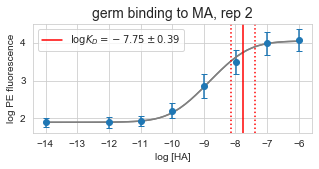

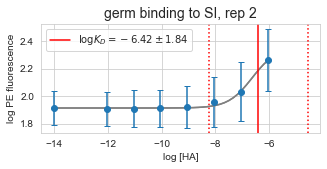

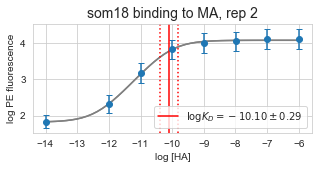

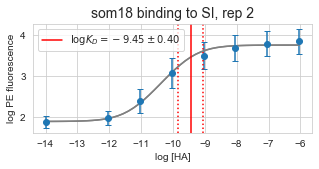

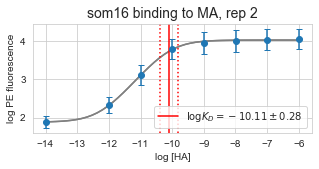

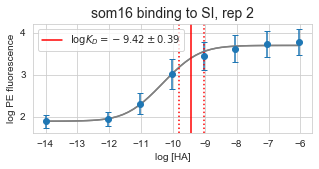

In [6]:
def sigmoid(c, Kd, A, B):
    return np.log10(A * (10**c/((10**c)+(10**Kd))) + B)

def rms(y, yfit):
    return np.sqrt(np.sum((y-yfit)**2))

n_runs = run_list.shape[0]
run_list['KD'] = np.zeros(n_runs)
run_list['KD_err'] = np.zeros(n_runs)

for i,run in enumerate(runs):
    mean_log_fluor = [df['log_PE'].mean() for df in run]
    std_log_fluor = [df['log_PE'].std() for df in run]
    antigen = run_list['antigen'][i]
    #adjust antigen concentration depending on replicate
    if not pd.isna(run_list['prefix'])[i]:
        antigen += '_angela'
    concs = (-concentrations_list[antigen]).copy()
    
    popt, pcov = scipy.optimize.curve_fit(sigmoid,
                                          concs,
                                          mean_log_fluor,
                                          p0=[(-9),10**(4),10**(1)],
                                          sigma=std_log_fluor,
                                          absolute_sigma=True,
                                          bounds = [((-14),1,1),((-5),10**(5),10**(5))],
                                          maxfev=400000)
    
    logKd = popt[0]
    logKd_err = np.sqrt(pcov[0][0])
    run_list.loc[i,'KD'] = logKd
    run_list.loc[i,'KD_err'] = logKd_err
    
    concs_plot = np.linspace(concs.min(), concs.max())
    
    plt.figure(figsize=(5,2))
    plt.errorbar(concs, mean_log_fluor, yerr=std_log_fluor, fmt='o', capsize=3)
    plt.plot(concs_plot, sigmoid(concs_plot, *popt), color='grey')
    plt.plot(concs_plot, sigmoid(concs_plot, *popt), color='grey')
    plt.axvline(logKd, linestyle='-', color='red',
               label=r'$\log K_D = %.2f \pm %.2f$' % (logKd, logKd_err))
    plt.axvline(logKd + logKd_err, linestyle=':', color='red')
    plt.axvline(logKd - logKd_err, linestyle=':', color='red')
    plt.xlabel('log [HA]')
    plt.ylabel('log PE fluorescence')
    plt.title('%s binding to %s, rep %s' %
              (run_list.loc[i,'shortname'],
               run_list.loc[i,'antigen'],
               run_list.loc[i,'replicate']),
              fontsize=14)
    plt.legend()
    plt.show()